Using device: cuda
Loading data...


100%|██████████| 170M/170M [00:05<00:00, 29.0MB/s]


Initializing model...
Total parameters: 1,496,707
Starting training...
Epoch 1/20, Batch 0/1563, Loss: 0.0693
Epoch 1/20, Batch 200/1563, Loss: 0.0109
Epoch 1/20, Batch 400/1563, Loss: 0.0117
Epoch 1/20, Batch 600/1563, Loss: 0.0066
Epoch 1/20, Batch 800/1563, Loss: 0.0114
Epoch 1/20, Batch 1000/1563, Loss: 0.0110
Epoch 1/20, Batch 1200/1563, Loss: 0.0076
Epoch 1/20, Batch 1400/1563, Loss: 0.0070
Epoch 1/20 completed - Avg Loss: 0.0088, Time: 26.11s
Epoch 2/20, Batch 0/1563, Loss: 0.0069
Epoch 2/20, Batch 200/1563, Loss: 0.0061
Epoch 2/20, Batch 400/1563, Loss: 0.0060
Epoch 2/20, Batch 600/1563, Loss: 0.0085
Epoch 2/20, Batch 800/1563, Loss: 0.0065
Epoch 2/20, Batch 1000/1563, Loss: 0.0083
Epoch 2/20, Batch 1200/1563, Loss: 0.0064
Epoch 2/20, Batch 1400/1563, Loss: 0.0060
Epoch 2/20 completed - Avg Loss: 0.0068, Time: 24.64s
Epoch 3/20, Batch 0/1563, Loss: 0.0070
Epoch 3/20, Batch 200/1563, Loss: 0.0069
Epoch 3/20, Batch 400/1563, Loss: 0.0048
Epoch 3/20, Batch 600/1563, Loss: 0.0069
E

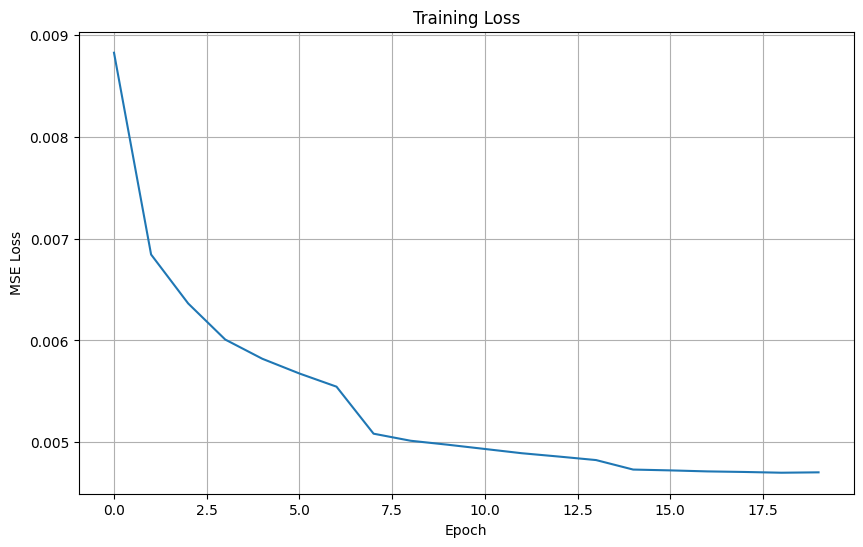


Evaluating model...
Test Loss: 0.0052
Estimated Accuracy: 99.48%

Visualizing results...


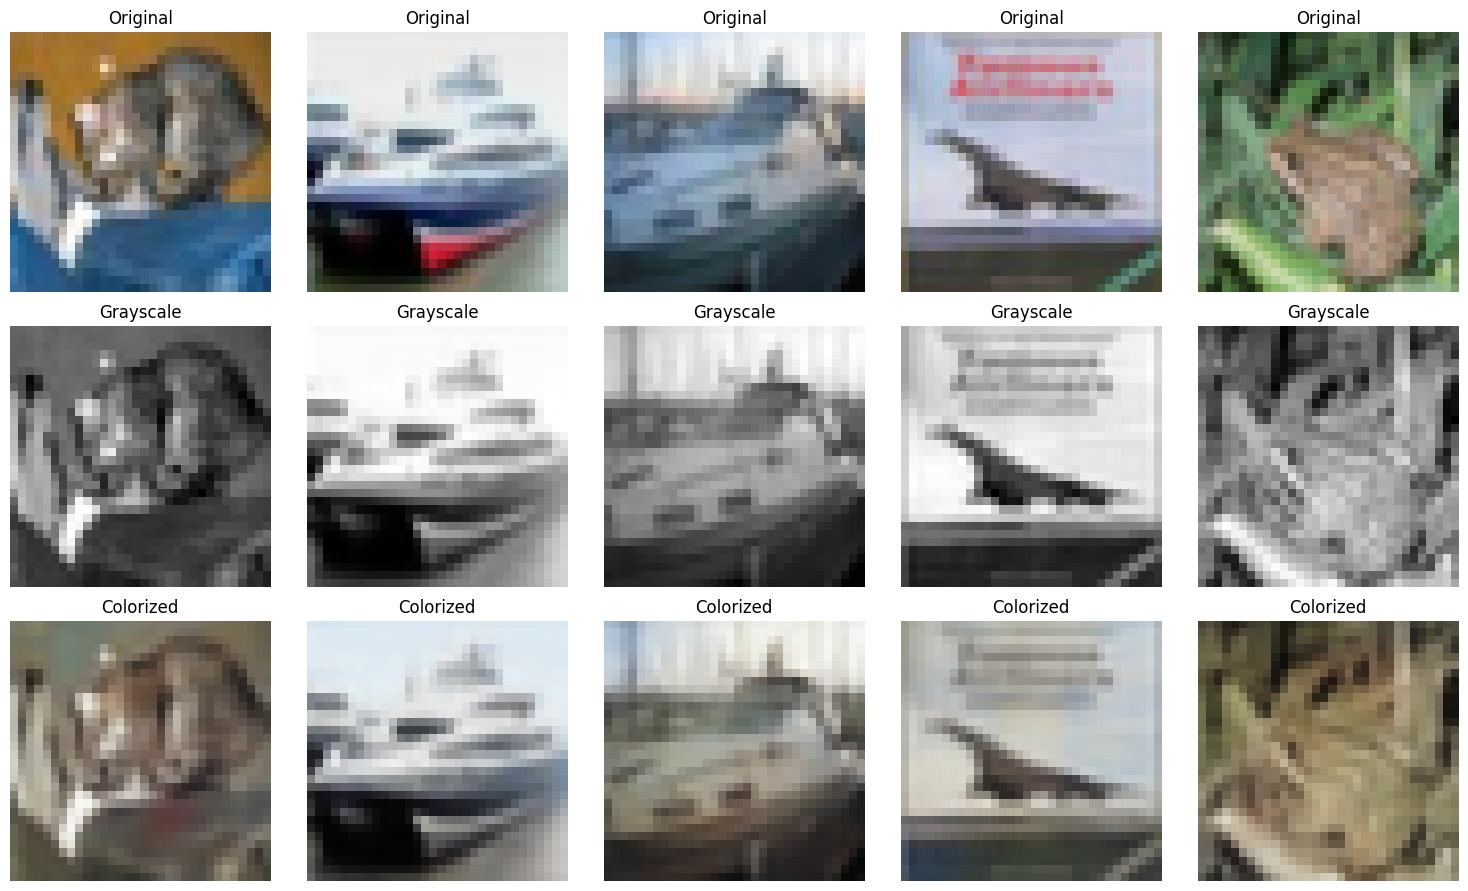


Model saved as: simple_colorization_model.pth
Complete model saved as: complete_colorization_model.pth


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
import time

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class SimpleColorizationNet(nn.Module):
    """
    Simplified U-Net architecture for image colorization
    Optimized for better performance and faster training
    """
    def __init__(self):
        super(SimpleColorizationNet, self).__init__()

        # Encoder (downsampling)
        self.encoder = nn.Sequential(
            # Layer 1: 1 -> 64
            nn.Conv2d(1, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            # Layer 2: 64 -> 128
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            # Layer 3: 128 -> 256
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )

        # Decoder (upsampling)
        self.decoder = nn.Sequential(
            # Upsample 1: 256 -> 128
            nn.ConvTranspose2d(256, 128, 2, stride=2),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            # Upsample 2: 128 -> 64
            nn.ConvTranspose2d(128, 64, 2, stride=2),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            # Final layer: 64 -> 3 (RGB)
            nn.Conv2d(64, 3, 3, padding=1),
            nn.Sigmoid()  # Output in [0,1] range
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

def rgb_to_grayscale(images):
    """Convert RGB images to grayscale using luminance formula"""
    weights = torch.tensor([0.299, 0.587, 0.114]).to(images.device).view(1, 3, 1, 1)
    return torch.sum(images * weights, dim=1, keepdim=True)

def setup_data_loaders(batch_size=32, num_workers=2):
    """Setup CIFAR-10 data loaders with appropriate transforms"""

    transform = transforms.Compose([
        transforms.Resize((32, 32)),  # Keep original CIFAR-10 size
        transforms.ToTensor(),
    ])

    # Load datasets
    train_dataset = torchvision.datasets.CIFAR10(
        root='./data', train=True, download=True, transform=transform
    )
    test_dataset = torchvision.datasets.CIFAR10(
        root='./data', train=False, download=True, transform=transform
    )

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size,
                            shuffle=True, num_workers=num_workers)
    test_loader = DataLoader(test_dataset, batch_size=batch_size,
                           shuffle=False, num_workers=num_workers)

    return train_loader, test_loader

def train_model(model, train_loader, num_epochs=20, learning_rate=0.001):
    """Train the colorization model"""

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    model.train()
    train_losses = []

    print("Starting training...")
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        start_time = time.time()

        for batch_idx, (images, _) in enumerate(train_loader):
            # Convert to grayscale and move to device
            grayscale = rgb_to_grayscale(images).to(device)
            color_target = images.to(device)

            # Forward pass
            optimizer.zero_grad()
            color_pred = model(grayscale)
            loss = criterion(color_pred, color_target)

            # Backward pass
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            # Print progress
            if batch_idx % 200 == 0:
                print(f'Epoch {epoch+1}/{num_epochs}, Batch {batch_idx}/{len(train_loader)}, '
                      f'Loss: {loss.item():.4f}')

        # Update learning rate
        scheduler.step()

        # Calculate average loss
        avg_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_loss)

        epoch_time = time.time() - start_time
        print(f'Epoch {epoch+1}/{num_epochs} completed - Avg Loss: {avg_loss:.4f}, '
              f'Time: {epoch_time:.2f}s')

    return train_losses

def evaluate_model(model, test_loader):
    """Evaluate model performance"""
    model.eval()
    total_loss = 0.0
    criterion = nn.MSELoss()

    with torch.no_grad():
        for images, _ in test_loader:
            grayscale = rgb_to_grayscale(images).to(device)
            color_target = images.to(device)
            color_pred = model(grayscale)

            loss = criterion(color_pred, color_target)
            total_loss += loss.item()

    avg_loss = total_loss / len(test_loader)
    accuracy = max(0, (1 - avg_loss) * 100)  # Convert loss to accuracy percentage

    print(f'Test Loss: {avg_loss:.4f}')
    print(f'Estimated Accuracy: {accuracy:.2f}%')

    return avg_loss, accuracy

def visualize_results(model, test_loader, num_samples=5):
    """Visualize colorization results"""
    model.eval()

    with torch.no_grad():
        for images, _ in test_loader:
            grayscale = rgb_to_grayscale(images).to(device)
            colorized = model(grayscale)

            # Convert to numpy for visualization
            original = images[:num_samples].cpu().numpy()
            gray = grayscale[:num_samples].cpu().squeeze(1).numpy()
            colored = colorized[:num_samples].cpu().numpy()

            # Create subplot
            fig, axes = plt.subplots(3, num_samples, figsize=(15, 9))

            for i in range(num_samples):
                # Original
                axes[0, i].imshow(np.transpose(original[i], (1, 2, 0)))
                axes[0, i].set_title('Original')
                axes[0, i].axis('off')

                # Grayscale
                axes[1, i].imshow(gray[i], cmap='gray')
                axes[1, i].set_title('Grayscale')
                axes[1, i].axis('off')

                # Colorized
                axes[2, i].imshow(np.transpose(colored[i], (1, 2, 0)))
                axes[2, i].set_title('Colorized')
                axes[2, i].axis('off')

            plt.tight_layout()
            plt.show()
            break

def colorize_custom_image(model, image_path, output_path="colorized_result.jpg"):
    """Colorize a custom image"""
    model.eval()

    # Load and preprocess image
    img = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
    ])

    img_tensor = transform(img).unsqueeze(0)
    grayscale = rgb_to_grayscale(img_tensor).to(device)

    # Generate colorized image
    with torch.no_grad():
        colorized = model(grayscale)

    # Convert back to PIL and save
    colorized_pil = transforms.ToPILImage()(colorized.squeeze(0).cpu())
    colorized_pil.save(output_path)

    # Display results
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    axes[0].imshow(img)
    axes[0].set_title('Original')
    axes[0].axis('off')

    axes[1].imshow(transforms.ToPILImage()(grayscale.squeeze(0).cpu()), cmap='gray')
    axes[1].set_title('Grayscale')
    axes[1].axis('off')

    axes[2].imshow(colorized_pil)
    axes[2].set_title('Colorized')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

    print(f"Colorized image saved as: {output_path}")

def main():
    """Main execution function"""

    # Configuration
    BATCH_SIZE = 32
    NUM_EPOCHS = 20
    LEARNING_RATE = 0.001

    # Setup data
    print("Loading data...")
    train_loader, test_loader = setup_data_loaders(BATCH_SIZE)

    # Initialize model
    print("Initializing model...")
    model = SimpleColorizationNet().to(device)

    # Print model info
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total parameters: {total_params:,}")

    # Train model
    train_losses = train_model(model, train_loader, NUM_EPOCHS, LEARNING_RATE)

    # Plot training progress
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.grid(True)
    plt.show()

    # Evaluate model
    print("\nEvaluating model...")
    test_loss, accuracy = evaluate_model(model, test_loader)

    # Visualize results
    print("\nVisualizing results...")
    visualize_results(model, test_loader)

    # Save model
    model_path = 'simple_colorization_model.pth'
    torch.save(model.state_dict(), model_path)
    print(f"\nModel saved as: {model_path}")

    # Save complete model for later use
    torch.save(model, 'complete_colorization_model.pth')
    print("Complete model saved as: complete_colorization_model.pth")

    return model

if __name__ == "__main__":
    # Run the main function
    trained_model = main()


Mounted at /content/drive


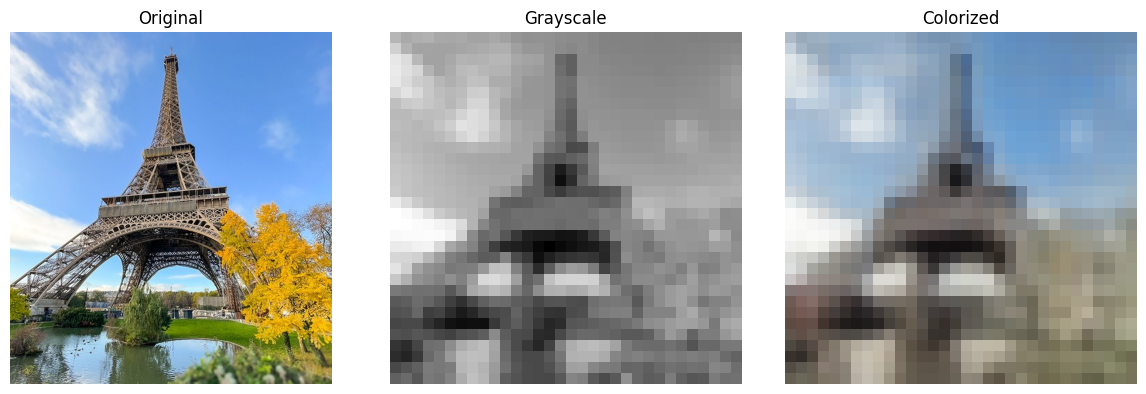

Colorized image saved as: colorized_result.jpg


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
custom_image_path = '/content/drive/MyDrive/home-discover-bg.jpg'
if os.path.exists(custom_image_path):
  colorize_custom_image(trained_model, custom_image_path)
else:
    print("Custom image not found. Please provide a valid image path.")